In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.3 MB/s eta 0:00:00


In [3]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap

In [4]:
import torch
torch.cuda.empty_cache()

In [5]:
# Inicialización
RANDOM_SEED = 42 # Semilla Aleatoria
MAX_LEN = 128
BATCH_SIZE = 16 #Bloque de 16
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/tweets_extraidos_preprocesados_sentimiento.csv' # Ruta Donde está almacenado el SET de datos
NCLASSES = 3

np.random.seed(RANDOM_SEED) # Inicializamos numpy con la semilla aleatoria
torch.manual_seed(RANDOM_SEED) # Inicializamos los parámetros del modelo Pytotch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Para usar la GPU para que el procesamiento sea más rápido
print(device)

cuda:0


In [6]:
# Cargar dataset original
from google.colab import drive #Leemos los datos de Drive
drive.mount('/content/drive')

df = pd.read_csv(DATASET_PATH) # Leemos el set de datos
df = df[0:10000] # tomamos una muestra de los datos para que el entrenamiento sea más rápido

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
columna = "Tweet Limpio"

# Verifica si hay valores nulos en la columna
valores_nulos = df[columna].isnull().sum()

# Imprime el número de valores nulos
print(f"Número de valores nulos en la columna {columna}: {valores_nulos}")

Número de valores nulos en la columna Tweet Limpio: 88


In [8]:
df = df.dropna(subset=[columna])

In [9]:
# Procedo a eliminar las columnas "Emoticones"
eliminar_columnas = ['Emoticones']
df = df.drop(columns = eliminar_columnas )

In [10]:
df.rename(columns={'Tweet Limpio': 'Tweet_Limpio'}, inplace=True)
df.rename(columns={'Analisis Sentimiento': 'Analisis_Sentimiento'}, inplace=True)

In [11]:
print(df.head()) # Imprime el encabezado
print(df.shape) # Imprime el tamaño del set de datos
print("\n".join(wrap(df['Tweet_Limpio'][200])))

          ID   ID_Texto              Nombre BD Nombre Usuario  \
0  110825732  110825732  Cantantes_Colombianos         Camilo   
1  110825732  110825732  Cantantes_Colombianos         Camilo   
2  110825732  110825732  Cantantes_Colombianos         Camilo   
3  110825732  110825732  Cantantes_Colombianos         Camilo   
4  110825732  110825732  Cantantes_Colombianos         Camilo   

                                      Tweet Original  \
0  Gallo pinto en Costa Rica... y otras maneras d...   
1  RT @rincondelatribu: La Tribu tiene casa, un h...   
2  Contando los días!! Ya quiero iiiiiiirrrrrr 🇧🇷...   
3  En el aeropuerto en Buenos Aires por salir a c...   
4  Recorriendo el mundo con mi esposa y mi hija h...   

                                  Tweet Preprocesado  \
0  gallo pinto costa rica ... manera disfrutar vi...   
1  rt @rincondelatribu : tribu casa , hogar , ⛺ \...   
2  contar ! ! querer iiiiiiirrrrrr 🇧 🇷 https://t....   
3  aeropuerto aires salir bolivia ! ! 🇧 🇴 \n dig

In [12]:
# Reajustar dataset
df['label'] = (df['Analisis_Sentimiento'] == 'POS').astype(int) * 2
df['label'] += (df['Analisis_Sentimiento'] == 'NEU').astype(int) * 1
df['label'] += (df['Analisis_Sentimiento'] == 'NEG').astype(int) * 0

df.drop('Analisis_Sentimiento', axis=1, inplace=True)
df.head()

,ID,ID_Texto,Nombre BD,Nombre Usuario,Tweet Original,Tweet Preprocesado,Tweet_Limpio,Sentimiento Score,Idioma,Retweet Count,Favorite_count,Followers_count,Friends_count,Listed_count,Favourites_count,Statuses_count,label
0,110825732,110825732,Cantantes_Colombianos,Camilo,Gallo pinto en Costa Rica... y otras maneras d...,gallo pinto costa rica ... manera disfrutar vi...,gallo pinto costa rica manera disfrutar vida,0.998737,es,177,4650,1735142,488,1442,3246,15649,2
1,110825732,110825732,Cantantes_Colombianos,Camilo,"RT @rincondelatribu: La Tribu tiene casa, un h...","rt @rincondelatribu : tribu casa , hogar , ⛺ \...",tribu casa hogar,0.996282,es,44,0,1735142,488,1442,3246,15649,2
2,110825732,110825732,Cantantes_Colombianos,Camilo,Contando los días!! Ya quiero iiiiiiirrrrrr 🇧🇷...,contar ! ! querer iiiiiiirrrrrr 🇧 🇷 https://t....,contar querer iiiiiiirrrrrr,0.998314,es,92,830,1735142,488,1442,3246,15649,1
3,110825732,110825732,Cantantes_Colombianos,Camilo,En el aeropuerto en Buenos Aires por salir a c...,aeropuerto aires salir bolivia ! ! 🇧 🇴 \n diga...,aeropuerto aires salir bolivia digan reco...,0.997631,es,26,396,1735142,488,1442,3246,15649,1
4,110825732,110825732,Cantantes_Colombianos,Camilo,Recorriendo el mundo con mi esposa y mi hija h...,recorrer mundo esposa hija amar . cambiar . .,recorrer mundo esposa hija amar cambiar,0.595363,es,122,3286,1735142,488,1442,3246,15649,1


In [13]:
valores_unicos = df['label'].unique()
print(valores_unicos)

[2 1 0]


In [14]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
# Ejemplo tokenización
sample_txt = 'Yo realmente amo este personaje!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids) # Esta representación numérica viene del modelo preentrenado

Frase:  Yo realmente amo este personaje!
Tokens:  ['Yo', 'realmente', 'amo', 'este', 'personaje', '!']
Tokens numéricos:  [1584, 3189, 5114, 1365, 7646, 1127]


In [16]:
# Codificación para introducir a BERT, esto nos sirve para insttroducir los tokens especiales de BERT.
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 10,
    truncation = True,
    add_special_tokens = True, # Tokens de inicio CLS y tokens de separación SEP
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True, # indica que se le preste atención a lo que hay dentro de los dos tokens especiales
    return_tensors = 'pt'
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'Yo', 'realmente', 'amo', 'este', 'personaje', '!', '[SEP]', '[PAD]', '[PAD]']
tensor([   4, 1584, 3189, 5114, 1365, 7646, 1127,    5,    1,    1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0])


In [19]:
# CREACIÓN DATASET

class ASMDataset(Dataset):

  def __init__(self,tweets,labels,tokenizer,max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.tweets)

  def __getitem__(self, item):
    Tweet_Limpio = str(self.tweets[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        Tweet_Limpio,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'tweet': Tweet_Limpio,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }

In [20]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = ASMDataset(
      tweets = df.Tweet_Limpio.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)
  # workers cambiado de 4 a 2

In [21]:
# Dividimos nuestro set de datos

df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
# Construimos el modelo - Red Neuronal

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()  # Inicializamos la clase
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False) # Cargar el modelo preentrenado
    self.drop = nn.Dropout(p=0.3) # Capa adicional para evitar el overfiting, apagar aleatoriamente en cada iteración el 30% de las neuronas, para hacer el modelo más robusto
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) # Capa

  def forward(self, input_ids, attention_mask): # Cómo están conectadas las capas y en qué orden deben pasar
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output) # Pasamos el token de clasificación
    output = self.linear(drop_output) # Tomar la red neuronal y tomar lo que esté en la salidad del drop_output
    return output


In [23]:
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
#print(model)


In [25]:
# Entrenamiento del modelo
EPOCHS = 5 # Iteraciones de entrenamiento
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS # Número total de iteraciones de entrenamiento
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0, # Cuántas iteraciones espera para empesar a reducir la tasa de aprendizaje
    num_training_steps = total_steps  # Npumero total de pasos de entrenamiento
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
# Iteración de entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = [] # Para almacenar el valor del error
  correct_predictions = 0 # Precisión en 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device) # Tomamos los tweets
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device) # Tomamos las etiquetas
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1) # Calcular las predicciones, sería la máxima que encuentre
    loss = loss_fn(outputs, labels) # Calcular la pérdida, introduciendo la salida y la etiqueta original
    correct_predictions += torch.sum(preds == labels) # Calcular la precisión
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Evitar que el gradiente crezca demasiado (Gradiente desendente), para evitar que el entrenamiento se estanque
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses) # Devuelve el valor de la precisión y el valor promedio del error

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval() # Poner el modelo en modo evaluación
  losses = [] # Calcular una pérdida
  correct_predictions = 0 # Calcular la precisión del modelo con los datos de validación
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item()) # almacene el valor del error
  return correct_predictions.double()/n_examples, np.mean(losses)

In [27]:
# Entrenamiento

for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
------------------
Entrenamiento: Loss: 0.5884932608403746, accuracy: 0.7825703115146928
Validación: Loss: 0.42586949557786985, accuracy: 0.8320726172465961

Epoch 2 de 5
------------------
Entrenamiento: Loss: 0.36272920111584805, accuracy: 0.8697187539412283
Validación: Loss: 0.4271221029301805, accuracy: 0.8426626323751892

Epoch 3 de 5
------------------
Entrenamiento: Loss: 0.2447693409264884, accuracy: 0.9166351368394501
Validación: Loss: 0.47860509818870456, accuracy: 0.8577912254160364

Epoch 4 de 5
------------------
Entrenamiento: Loss: 0.16022050102906032, accuracy: 0.9563627191322991
Validación: Loss: 0.624308853958463, accuracy: 0.859808371154816

Epoch 5 de 5
------------------
Entrenamiento: Loss: 0.1335509858763544, accuracy: 0.9677134569302559
Validación: Loss: 0.6617854488393923, accuracy: 0.8577912254160364



In [28]:
def classifySentiment(tweet_text):
  encoding_tweet = tokenizer.encode_plus(
      tweet_text,
      max_length = MAX_LEN,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
      )

  input_ids = encoding_tweet['input_ids'].to(device)
  attention_mask = encoding_tweet['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print("\n".join(wrap(tweet_text)))

  if prediction == 1:
    print('Sentimiento predicho: Neutro')
  elif prediction == 2:
    print('Sentimiento predicho: Positivo')
  elif prediction == 0:
    print('Sentimiento predicho: Negativo')
  else:
    print('Valor de predicción no válido')


In [29]:
review_text = "Hoy es un día maravilloso para disfrutar del sol y la playa."

classifySentiment(review_text)

Hoy es un día maravilloso para disfrutar del sol y la playa.
Sentimiento predicho: Positivo


In [30]:
review_text="El día de la boda fue tan emocionante que me hizo llorar"
classifySentiment(review_text)

El día de la boda fue tan emocionante que me hizo llorar
Sentimiento predicho: Positivo


In [31]:
review_text="Aunque llovió durante todo el picnic, aún así disfrutamos."
classifySentiment(review_text)

Aunque llovió durante todo el picnic, aún así disfrutamos.
Sentimiento predicho: Positivo


In [32]:
review_text="El informe que entregué hoy fue aceptado sin problemas"
classifySentiment(review_text)

El informe que entregué hoy fue aceptado sin problemas
Sentimiento predicho: Neutro


In [33]:
review_text="Estuve todo el día en casa trabajando en mi proyecto"
classifySentiment(review_text)



Estuve todo el día en casa trabajando en mi proyecto
Sentimiento predicho: Neutro


In [35]:
df_train.head()

,ID,ID_Texto,Nombre BD,Nombre Usuario,Tweet Original,Tweet Preprocesado,Tweet_Limpio,Sentimiento Score,Idioma,Retweet Count,Favorite_count,Followers_count,Friends_count,Listed_count,Favourites_count,Statuses_count,label
9223,44670915,44670915,Cantantes_Colombianos,J BALVIN,Es nuestra responsabilidad estar en casa y cui...,responsabilidad casa cuidarno . pasar .,responsabilidad casa cuidarno pasar,0.920552,es,6920,39298,10820447,542,7238,770,31734,1
8702,44670915,44670915,Cantantes_Colombianos,J BALVIN,Jose por J Balvin \nhttps://t.co/erTKLPRcWc ht...,jose j balvin \n https://t.co/ertklprcwc https...,jose j balvin,0.997043,en,237,4625,10820447,542,7238,770,31734,1
8492,44670915,44670915,Cantantes_Colombianos,J BALVIN,Que Locura ⚡️⚡️⚡️ https://t.co/qs4qOSlxnn,locura ⚡ ️ ⚡ ️ ⚡ ️ https://t.co/qs4qoslxnn,locura,0.967180,es,91,1439,10820447,542,7238,770,31734,0
7866,323976919,323976919,Cantantes_Colombianos,Greeicy Rendon,Abuelo @rafataibo http://t.co/vXMmIAlC0Y,abuelo @rafataibo http://t.co/vxmmialc0y,abuelo,0.976709,es,1,1,478258,210,261,270,4514,1
4437,45580261,45580261,Cantantes_Colombianos,Fonseca,@ManoloCardona A mi también por favor que no e...,@manolocardón favor entender … ..,favor entender,0.998575,es,2,47,4126980,987,6205,11768,19484,1


In [36]:
!pip install tabulate

In [37]:
import matplotlib.pyplot as plt

In [39]:
from tabulate import tabulate
# Usar groupby para agrupar por la columna "Grupo" y luego sumar la columna "Valor"
result = df_train.groupby('Nombre BD')['Retweet Count'].sum().reset_index()
# Mostrar los resultados en una tabla
table1 = tabulate(result, headers='keys', tablefmt='pretty', showindex=False)

# Imprimir la tabla
print(table1)

+-----------------------+---------------+
|       Nombre BD       | Retweet Count |
+-----------------------+---------------+
| Cantantes_Colombianos |    1766166    |
+-----------------------+---------------+


In [41]:
# Tabla que muestra la frecuencia de cada sentimiento para cada valor único de nombre_bd
tabla = pd.crosstab(df_train['Nombre BD'], df_train['label'])
print(tabla)

label                    0     1     2
Nombre BD                             
Cantantes_Colombianos  530  5142  2257


In [42]:
# Calcular el promedio de 'Retweet Count' para cada combinación de "Nombre BD" y "Sentimiento"
promedio_retweets_por_polaridad_y_bd = df_train.pivot_table(values='Retweet Count', index='Nombre BD', columns='label', aggfunc='mean')

# Imprimir el resultado
print(promedio_retweets_por_polaridad_y_bd)

label                           0           1           2
Nombre BD                                                
Cantantes_Colombianos  312.669811  237.278491  168.526805


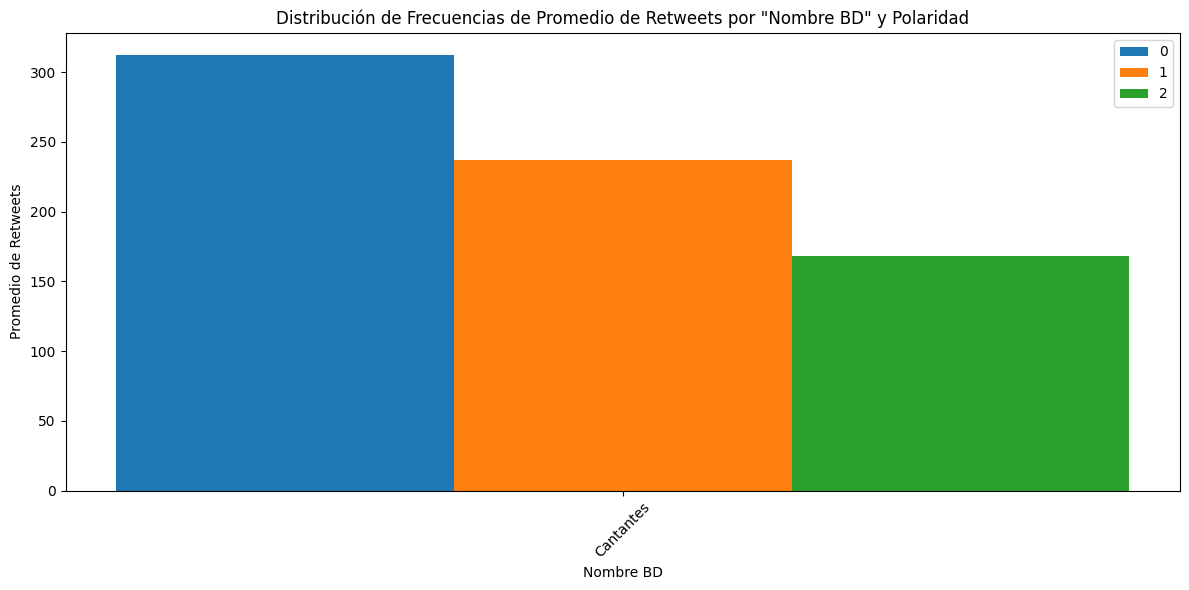

In [43]:
# Obtener las categorías de "Nombre BD" y las polaridades
categorias = promedio_retweets_por_polaridad_y_bd.index
polaridades = promedio_retweets_por_polaridad_y_bd.columns

nombres_base_datos = {
    'Cantantes_Colombianos': 'Cantantes',
    'Deportistas_Colombianos': 'Deportistas',
    'Empresas_Colombianas': 'Empresas',
    'Famosos': 'Famosos',
    'Futbol_Colombiano': 'Futbol',
    'Instituciones_del_Estado_Colombiano': 'Instituciones',
    'Medios_Informaticos': 'Medios',
    'Periodistas': 'Periodistas',
    'Politicos_Colombianos': 'Politicos',
    'Universidades_Colombianas': 'Universidades',
    # Agrega más nombres aquí si es necesario
}
# Configurar el ancho de las barras
ancho_barra = 0.2
indice = np.arange(len(categorias))

# Crear un gráfico de barras agrupadas
plt.figure(figsize=(12, 6))  # Ajustar el tamaño del gráfico

for i, polaridad in enumerate(polaridades):
    promedios = promedio_retweets_por_polaridad_y_bd[polaridad]
    plt.bar(indice + i * ancho_barra, promedios, width=ancho_barra, label=polaridad)

plt.xlabel('Nombre BD')
plt.ylabel('Promedio de Retweets')
plt.title('Distribución de Frecuencias de Promedio de Retweets por "Nombre BD" y Polaridad')
plt.legend()
# Reemplazar los nombres de bases de datos en el eje x utilizando el diccionario
nombres_reemplazados = [nombres_base_datos.get(cat, cat) for cat in categorias]
plt.xticks(indice + (len(polaridades) - 1) * ancho_barra / 2, nombres_reemplazados, rotation=45)
plt.tight_layout()
plt.show()

In [44]:
# Calcular el promedio de 'Followers_count' para cada combinación de "Nombre BD" y "Sentimiento"
promedio_followers_count_por_polaridad_y_bd = df_train.pivot_table(values='Followers_count', index='Nombre BD', columns='label', aggfunc='mean')

# Imprimir el resultado
print(promedio_followers_count_por_polaridad_y_bd)

label                             0             1             2
Nombre BD                                                      
Cantantes_Colombianos  3.463708e+06  3.777727e+06  3.103921e+06


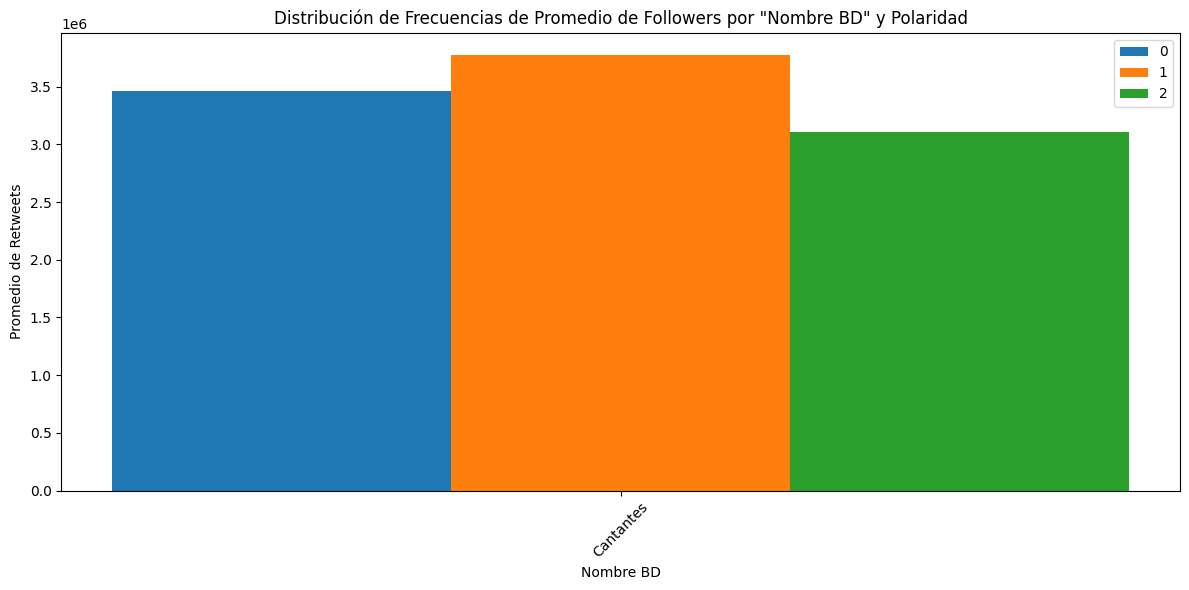

In [45]:
# Obtener las categorías de "Nombre BD" y las polaridades
categorias = promedio_followers_count_por_polaridad_y_bd.index
polaridades = promedio_followers_count_por_polaridad_y_bd.columns

nombres_base_datos = {
    'Cantantes_Colombianos': 'Cantantes',
    'Deportistas_Colombianos': 'Deportistas',
    'Empresas_Colombianas': 'Empresas',
    'Famosos': 'Famosos',
    'Futbol_Colombiano': 'Futbol',
    'Instituciones_del_Estado_Colombiano': 'Instituciones',
    'Medios_Informaticos': 'Medios',
    'Periodistas': 'Periodistas',
    'Politicos_Colombianos': 'Politicos',
    'Universidades_Colombianas': 'Universidades',
    # Agrega más nombres aquí si es necesario
}
# Configurar el ancho de las barras
ancho_barra = 0.2
indice = np.arange(len(categorias))

# Crear un gráfico de barras agrupadas
plt.figure(figsize=(12, 6))  # Ajustar el tamaño del gráfico

for i, polaridad in enumerate(polaridades):
    promedios = promedio_followers_count_por_polaridad_y_bd[polaridad]
    plt.bar(indice + i * ancho_barra, promedios, width=ancho_barra, label=polaridad)

plt.xlabel('Nombre BD')
plt.ylabel('Promedio de Retweets')
plt.title('Distribución de Frecuencias de Promedio de Followers por "Nombre BD" y Polaridad')
plt.legend()
# Reemplazar los nombres de bases de datos en el eje x utilizando el diccionario
nombres_reemplazados = [nombres_base_datos.get(cat, cat) for cat in categorias]
plt.xticks(indice + (len(polaridades) - 1) * ancho_barra / 2, nombres_reemplazados, rotation=45)
plt.tight_layout()
plt.show()

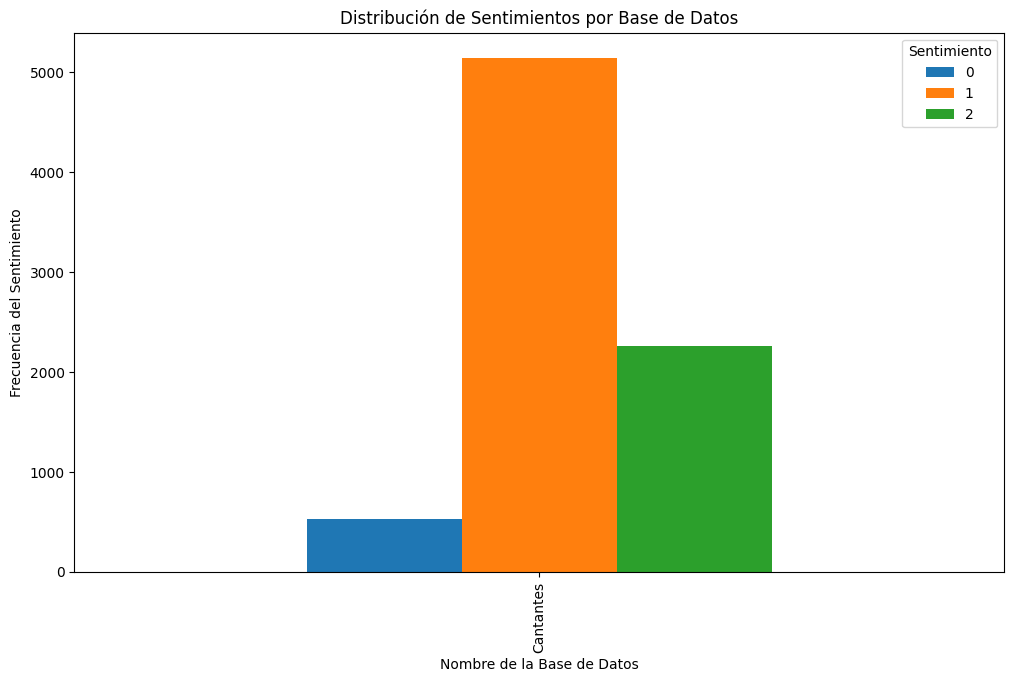

In [46]:
# Gráfico de barras agrupadas para visualizar la distribución
nombres_base_datos = {
    'Cantantes_Colombianos': 'Cantantes',
    'Deportistas_Colombianos': 'Deportistas',
    'Empresas_Colombianas': 'Empresas',
    'Famosos': 'Famosos',
    'Futbol_Colombiano': 'Futbol',
    'Instituciones_del_Estado_Colombiano': 'Instituciones',
    'Medios_Informaticos': 'Medios',
    'Periodistas': 'Periodistas',
    'Politicos_Colombianos': 'Politicos',
    'Universidades_Colombianas': 'Universidades',
    # Agrega más nombres aquí si es necesario
}

# Crea el gráfico de barras agrupadas
ax = tabla.plot(kind='bar', figsize=(12, 7))

# Obtiene las etiquetas actuales en el eje x
etiquetas_actuales = [tick.get_text() for tick in ax.get_xticklabels()]

# Crea una lista de etiquetas renombradas usando el diccionario
etiquetas_renombradas = [nombres_base_datos.get(etiqueta, etiqueta) for etiqueta in etiquetas_actuales]

# Establece las etiquetas renombradas en el eje x
ax.set_xticklabels(etiquetas_renombradas)

# Personaliza otros aspectos del gráfico
plt.title('Distribución de Sentimientos por Base de Datos')
plt.xlabel('Nombre de la Base de Datos')
plt.ylabel('Frecuencia del Sentimiento')
plt.legend(title='Sentimiento', loc='upper right')
plt.show()